Given the unnormalized density: $p(x)=\exp(-x^2/2)(\sin(x)^2+3\cos(x)^2*\sin(7x)^2+1)$ for $x\in[-3,3]$ , the task is to sample from this distribution and calculate $E(x^2)$.

Calculate it using Pyro's NUTS (sampler) (with warm-up and number of chains >1). For convenience, we provide the following template: Colab Notebook . Use arviz to perform diagnostics.

In [38]:
import torch
import pyro
import pyro.distributions as pdist
import torch.distributions as tdist
import arviz
import numpy as np
from pyro.infer import MCMC, NUTS
from torch.distributions import constraints
import matplotlib.pyplot as plt
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

In [39]:

class MyDensity(pdist.TorchDistribution):
    # The integration interval
    support = constraints.interval(-3,3) 
    
    # Constraint for the starting value used in the sampling
    # (should be within integration interval)
    arg_constraints = {"start": support}

    def __init__(self, start=torch.tensor(0.0)):
      # start = starting value for HMC sampling, default 0
      self.start = start
      super(pdist.TorchDistribution, self).__init__()

    def sample(self, sample_shape=torch.Size()):
        # This is only used to start the HMC sampling
        # It simply returns the starting value for the sampling
        return self.start

    def log_prob(self, x):
        # Return log of the (unnormalized) density
        dens= torch.exp(-x**2/2)*(torch.sin(x)**2+3*torch.cos(x)**2*torch.sin(7*x)**2+1)
        
        if torch.any(x < -3) or torch.any(x > 3):
            return torch.tensor(float('-inf')).to(x.device)
        
        return torch.log(dens) 


In [40]:
# Specify the model, which in our case is just our MyDensity distribution

def model():
    # Use your custom distribution, MyDensity
    pyro.sample('x', MyDensity())


In [43]:
# Run HMC / NUTS

no_chains =1

nuts_kernel = NUTS(model) 

mcmc= MCMC(nuts_kernel, num_samples=1000, warmup_steps=500, num_chains=no_chains) 

mcmc.run()

Sample: 100%|██████████| 1500/1500 [00:06, 239.32it/s, step size=1.44e-01, acc. prob=0.889]


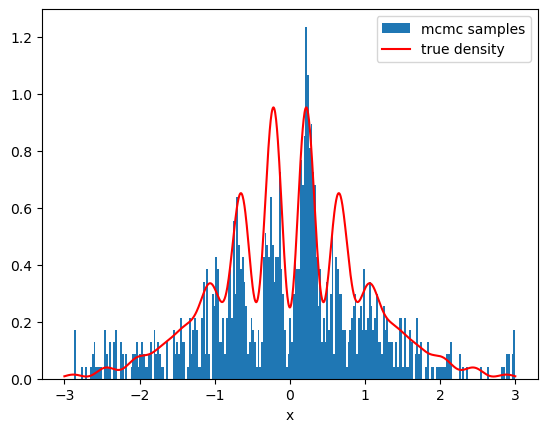

In [44]:

posterior_samples = mcmc.get_samples()

fig, ax = plt.subplots()
ax.hist(posterior_samples['x'].numpy(), bins=250, density=True, label='mcmc samples')
ax.set_xlabel('x')
x1=np.linspace(-3,3,1000)
ax.plot(x1, np.exp(-x1**2/2)*(np.sin(x1)**2+3*np.cos(x1)**2*np.sin(7*x1)**2+1)/4, 'r', label='true density')
ax.legend()
plt.show()



In [10]:
# calculate E[x**2]

def est_2moment(samples):
    return np.mean(np.array(samples)**2)

samples=posterior_samples['x'].numpy()

print('The estimate for E(x^2) is:',est_2moment(samples))


The estimate for E(x^2) is: 0.9087584


In [59]:
rounds=500 #change to 500 to compare to other script

est_mcmc=[]

for n in [10,100,1000]:
    mc=[]
    
    for i in range(rounds):
        nuts_kernel = NUTS(model) 
        mcmc = MCMC(nuts_kernel, num_samples=n, warmup_steps=100, num_chains = no_chains) 
        mcmc.run()
        posterior_samples = mcmc.get_samples()
        samples= posterior_samples['x'].numpy()
        mc.append(est_2moment(samples))

    est_mcmc.append([np.mean(mc),np.std(mc)])



Sample: 100%|██████████| 1100/1100 [00:03, 329.27it/s, step size=2.42e-01, acc. prob=0.754]


[0.97786695, 0.90715694, 0.917728] [0.9459844, 0.34834242, 0.11187836]


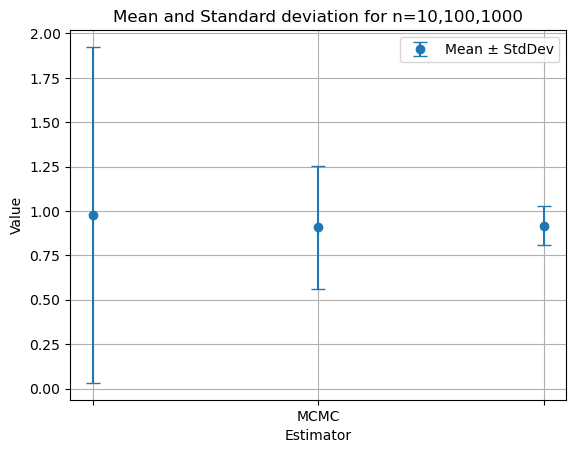

In [61]:
means=[est_mcmc[i][0] for i in range(3)]
stds=[est_mcmc[i][1] for i in range(3)]
print(means,stds)

x_positions = [0.2,0.4,0.6]  # X-axis positions for each list
plt.errorbar(x_positions, means, yerr=stds, fmt='o', capsize=5, label='Mean ± StdDev')

# Add labels, title, and legend
plt.xticks(x_positions, ['','MCMC', ''])  # Label each list
plt.xlabel('Estimator')
plt.ylabel('Value')
plt.title('Mean and Standard deviation for n=10,100,1000')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

256
The estimate for E(x^2) is: 0.9194472387288926


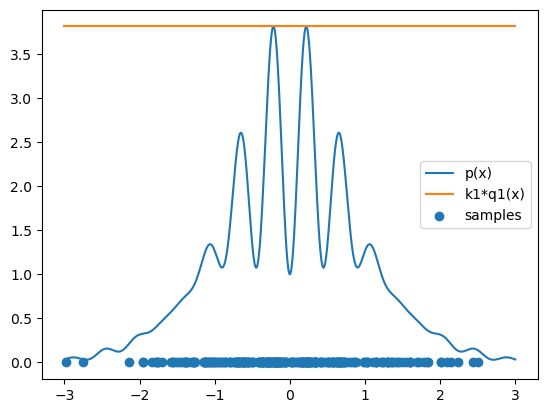

579
The estimate for E(x^2) is: 1.0043168210142954


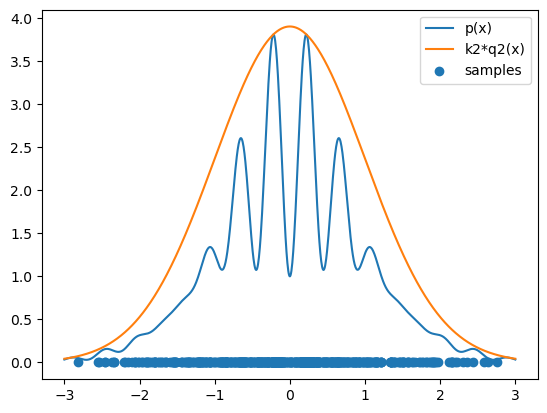

The estimate for E(x^2) is: 0.97479389154645


/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


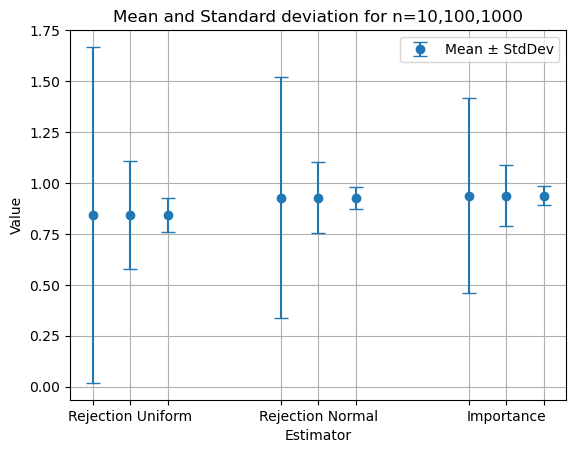

In [63]:
%run 'ex3.ipynb'

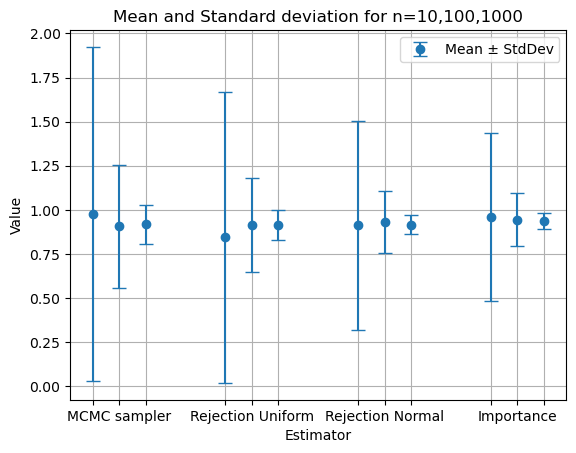

In [72]:
# Store lists in a single array for easier processing
data = [est_mcmc, est_rejection_unif, est_rejection_norm, est_importance]

# Calculate means and standard deviations
means = [data[i][j][0] for i in range(len(data)) for j in range(len(data[i]))]
std_devs = [data[i][j][1] for i in range(len(data)) for j in range(len(data[i]))]

# Plotting
x_positions = [0.2,0.4,0.6, 1.2,1.4,1.6, 2.2,2.4,2.6, 3.2,3.4,3.6]  # X-axis positions for each list
plt.errorbar(x_positions, means, yerr=std_devs, fmt='o', capsize=5, label='Mean ± StdDev')

# Add labels, title, and legend
plt.xticks(x_positions, ['','MCMC sampler', '', 
                         '','Rejection Uniform', '', 
                         '','Rejection Normal','',
                         '','Importance',''])  # Label each list
plt.xlabel('Estimator')
plt.ylabel('Value')
plt.title('Mean and Standard deviation for n=10,100,1000')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# TODO use arviz to summarize and investigate: plot
data = arviz.from_pyro(mcmc)

summary = None

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 nan


In [ ]:
# HMC / NUTS
def HMC(n_samples):
    # Run HMC / NUTS
    nuts_kernel=None
    mcmc= None
    # Do something with the mcmc object here ...

    # TODO Get the samples
    samples = None

    # TODO: Calculate E(x^2)
    expected_val = None
    return expected_val

In [ ]:
# TODO make figures w.r.t. different sample sizes, samplers, etc.